In [2]:
import matplotlib.pyplot as plt
import numpy as np
import h5py
import time

plt.rcParams.update({'font.size': 18})

In [3]:
def h5file2corr(h5_file, NFFT):
    print ("Reading",h5_file)
    with h5py.File(h5_file, 'r') as hf: 
        fc = hf["data"].attrs['fc']
        fs = hf["data"].attrs['fs']
        c  = hf["data"].attrs['c']
        len_data = hf["data/timestamps"][()].shape[0]
        print (len_data)
        Nsamp = int(c)

        auto11 = np.zeros(NFFT, dtype=np.complex64)
        auto22 = np.zeros(NFFT, dtype=np.complex64)
        cross12 = np.zeros(NFFT, dtype=np.complex64)

        for i in range(len_data):
            a = hf["data/samples"][i][0][:]
            b = hf["data/samples"][i][1][:]

            for j in range(int(Nsamp/NFFT)):
                c1_fft = np.fft.fft(a[j*NFFT:(j+1)*NFFT])
                c2_fft = np.fft.fft(b[j*NFFT:(j+1)*NFFT])
                auto11 = auto11 + c1_fft*np.conj(c1_fft)
                auto22 = auto22 + c2_fft*np.conj(c2_fft)
                cross12 = cross12 + c1_fft*np.conj(c2_fft)

    auto11 = np.fft.fftshift(auto11)
    auto22 = np.fft.fftshift(auto22)
    cross12 = np.fft.fftshift(cross12)
    freqs = np.fft.fftshift(np.fft.fftfreq(NFFT, 1/fs)+fc)
    hf.close()
    return freqs, auto11, auto22, cross12


In [4]:
def gamma_transfer_func(S11_here, S12_here, S21_here, S22_here, Gamma_here):
    Gamma_prime_here = S11_here + ( S12_here * S21_here * Gamma_here/(1 - S22_here*Gamma_here))
    return Gamma_prime_here

def de_embed(S11_here, Diff_here, S22_here, Gamma_prime_here):
    Gamma_here = (Gamma_prime_here - S11_here)/(Diff_here + S22_here*Gamma_prime_here)
    return Gamma_here

In [5]:
freqs_open, auto11_open, auto22_open, cross12_open     = h5file2corr("20240217-155230_pluto_open.h5", 512)
freqs_short, auto11_short, auto22_short, cross12_short = h5file2corr("20240217-155301_pluto_short.h5", 512)
freqs_load, auto11_load, auto22_load, cross12_load     = h5file2corr("20240217-155333_pluto_load.h5", 512)
freqs_ksr100, auto11_ksr100, auto22_ksr100, cross12_ksr100 = h5file2corr("20240217-155450_pluto_ksr100.h5", 512)

Reading 20240217-155230_pluto_open.h5
100
Reading 20240217-155301_pluto_short.h5
100
Reading 20240217-155333_pluto_load.h5
100
Reading 20240217-155450_pluto_ksr100.h5
100


Text(0.5, 0, 'Freq (MHz)')

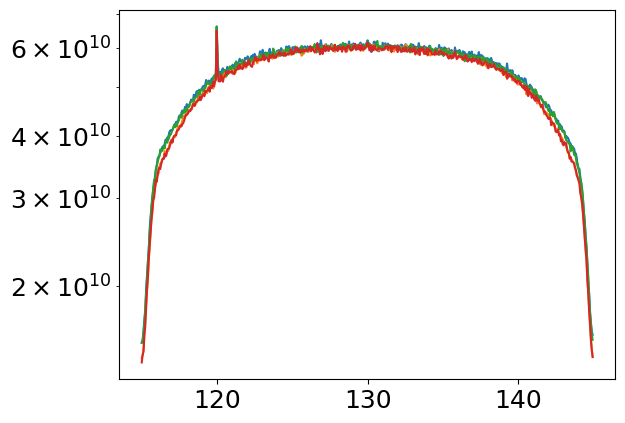

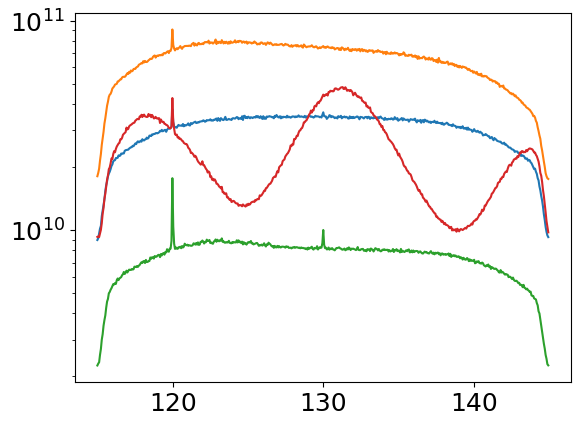

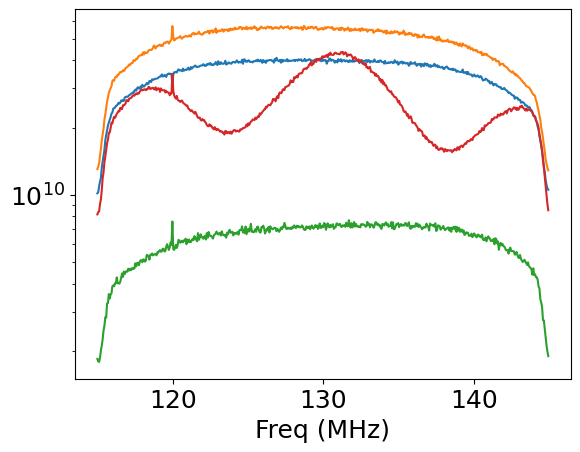

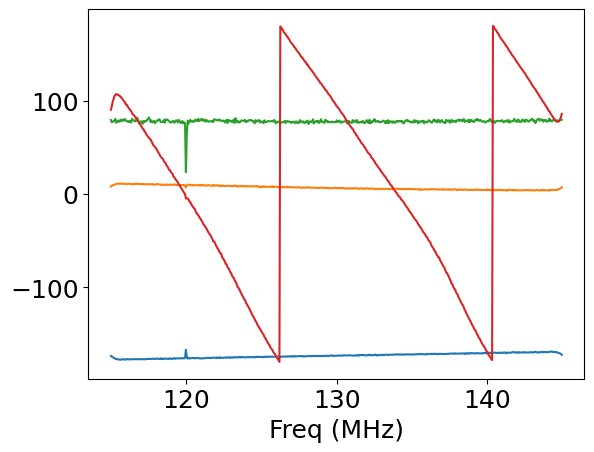

In [6]:
plt.figure()
plt.semilogy(freqs_open/1e6, np.abs(auto22_open))
plt.semilogy(freqs_open/1e6, np.abs(auto22_short))
plt.semilogy(freqs_open/1e6, np.abs(auto22_load))
plt.semilogy(freqs_open/1e6, np.abs(auto22_ksr100))

plt.figure()
plt.semilogy(freqs_open/1e6, np.abs(auto11_open))
plt.semilogy(freqs_open/1e6, np.abs(auto11_short))
plt.semilogy(freqs_open/1e6, np.abs(auto11_load))
plt.semilogy(freqs_open/1e6, np.abs(auto11_ksr100))

plt.figure()
plt.semilogy(freqs_open/1e6, np.abs(cross12_open))
plt.semilogy(freqs_open/1e6, np.abs(cross12_short))
plt.semilogy(freqs_open/1e6, np.abs(cross12_load))
plt.semilogy(freqs_open/1e6, np.abs(cross12_ksr100))

plt.xlabel("Freq (MHz)")

plt.figure()
# plt.plot(freqs_open/1e6, np.unwrap(np.angle(cross12_open)))
# plt.plot(freqs_open/1e6, np.unwrap(np.angle(cross12_short)))
# plt.plot(freqs_open/1e6, np.unwrap(np.angle(cross12_load)))
# plt.plot(freqs_open/1e6, np.unwrap(np.angle(cross12_ksr100)))

plt.plot(freqs_open/1e6, (np.angle(cross12_open))*180/np.pi)
plt.plot(freqs_open/1e6, (np.angle(cross12_short))*180/np.pi)
plt.plot(freqs_open/1e6, (np.angle(cross12_load))*180/np.pi)
plt.plot(freqs_open/1e6, (np.angle(cross12_ksr100))*180/np.pi)

plt.xlabel("Freq (MHz)")


In [7]:
Gamma_open = cross12_open
Gamma_short = cross12_short
Gamma_load = cross12_load
Gamma_KSR100 = cross12_ksr100

S11_RP = Gamma_open*1.0
Diff_RP = Gamma_open*1.0
S22_RP = Gamma_open*1.0
Gamma_KSR100_cal = Gamma_KSR100*1.0 # to get array size correct

In [13]:
EDF_array = np.array([])
ESF_array = np.array([])
diff_array = np.array([])
for i in range(len(freqs_open)):

    # Let us assume the models as follows
    Gamma_open_model = 1.0
    Gamma_short_model = -1.0
    Gamma_load_model = 0.00

    # We will try to recover the S params of the RP now.
    Measure_matrix = np.array([[1, Gamma_open_model, Gamma_open_model*Gamma_open[i]],
                                [1, Gamma_short_model, Gamma_short_model*Gamma_short[i]],
                                [1, Gamma_load_model, Gamma_load_model*Gamma_load[i]]])

    Gamma_matrix_measu = np.array([Gamma_open[i], Gamma_short[i], Gamma_load[i]])

    reco_para = np.matmul(np.linalg.pinv(Measure_matrix), Gamma_matrix_measu)

    S11_RP[i] = reco_para[0]
    Diff_RP[i] = reco_para[1]
    S22_RP[i] = reco_para[2]
    
    EDF_array = np.append(EDF_array, S11_RP[i])
    ESF_array = np.append(ESF_array, S22_RP[i])
    diff_array = np.append(ESF_array, Diff_RP[i])

    # Let us de-embed (calibrate) measured RLC values.
    Gamma_KSR100_cal[i] = de_embed(S11_RP[i], Diff_RP[i], S22_RP[i], Gamma_KSR100[i])

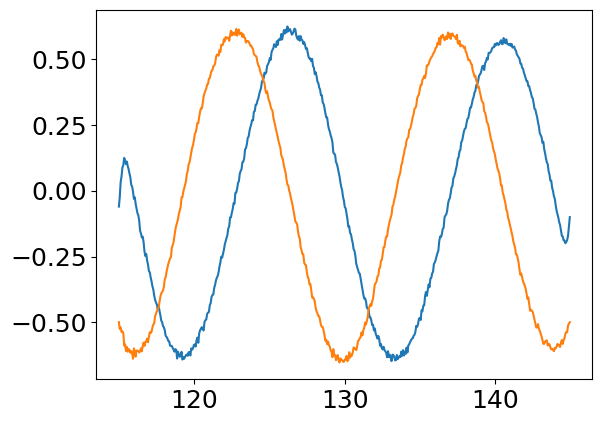

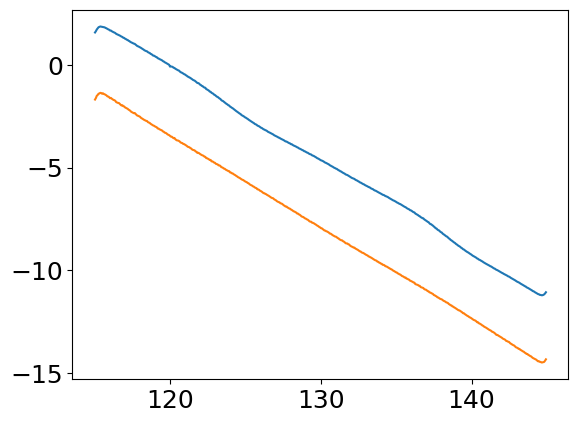

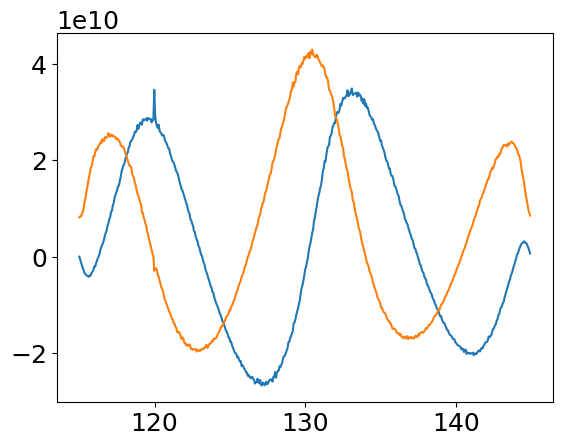

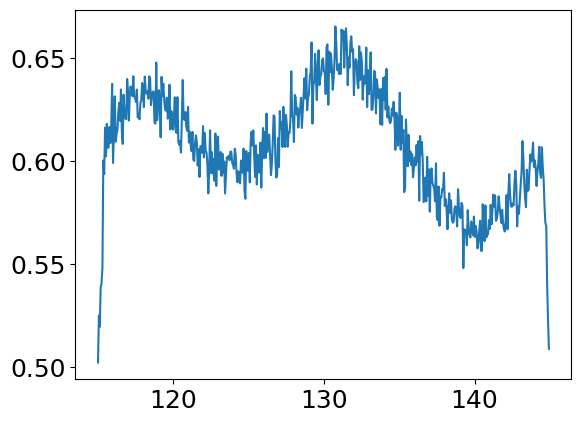

In [20]:
plt.figure()
plt.plot(freqs_open/1e6, np.real(Gamma_KSR100_cal))
plt.plot(freqs_open/1e6, np.imag(Gamma_KSR100_cal))

plt.figure()
plt.plot(freqs_open/1e6, np.unwrap(np.angle(Gamma_KSR100)))
plt.plot(freqs_open/1e6, np.unwrap(np.angle(Gamma_KSR100_cal)))

plt.figure()
plt.plot(freqs_open/1e6, np.real(Gamma_KSR100))
plt.plot(freqs_open/1e6, np.imag(Gamma_KSR100))

plt.figure()
# plt.plot(np.abs(Gamma_KSR100))
plt.plot(freqs_open/1e6, np.abs(Gamma_KSR100_cal))

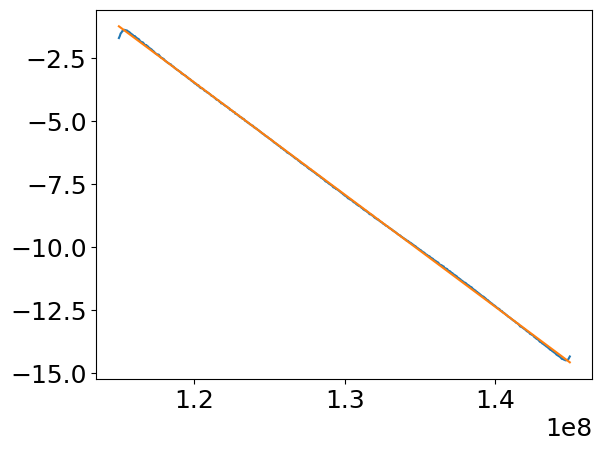

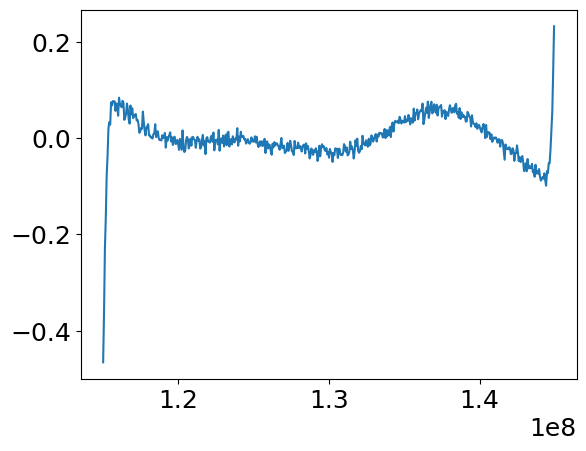

In [26]:
pfit_c = np.polyfit(freqs_ksr100, np.unwrap(np.angle(Gamma_KSR100_cal)), 1)
pfit = np.polyval(pfit_c, freqs_ksr100)
plt.figure()
plt.plot(freqs_ksr100, np.unwrap(np.angle(Gamma_KSR100_cal)))
plt.plot(freqs_ksr100, pfit)

plt.figure()
plt.plot(freqs_ksr100, np.unwrap(np.angle(Gamma_KSR100_cal))-pfit)